In [2]:
from flax import linen as nn 
from flax.linen import initializers
from flax.core import freeze, unfreeze
from flax.linen.module import compact
from basic import logprior_fn, logvariational_fn, samplevariational_fn, sigmas_from_rhos
from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as random
from jax import lax
PRNGKey = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?
Array = Any
default_kernel_init = initializers.lecun_normal()
from jax.random import PRNGKey, split
import optax

In [3]:
class BNNLayer(nn.Module):

    features: int
    prior_pi: float
    prior_var1: float
    prior_var2: float
    parameter_init: Callable = nn.initializers.lecun_normal()

    @compact
    def __call__(self, key: random.PRNGKey, inputs):
        # Variational Parameters
        mus = self.param(
            "mus", 
            self.parameter_init, 
            (jnp.shape(inputs)[-1] + 1, self.features)) # +1 for bias
        rhos = self.param(
            "rhos",
            self.parameter_init,
            (jnp.shape(inputs)[-1] + 1, self.features) # +1 for bias
        )

        # Sample weights
        weights_and_biases = samplevariational_fn(
            mus=mus,
            rhos=rhos,
            key=key,
        )


        weights = weights_and_biases[:-1]
        biases = weights_and_biases[-1]

        

        y = jnp.dot(inputs, weights) + biases


        log_variational_density = logvariational_fn(
            weights=weights,
            mus=mus,
            rhos=rhos,
        )
        log_prior_density = logprior_fn(
            weights=weights,
            pi=self.prior_pi,
            var1=self.prior_var1,
            var2=self.prior_var2,
        )
        return y, log_variational_density, log_prior_density



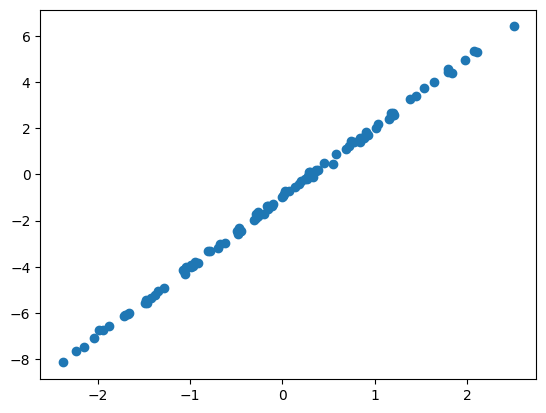

In [5]:
import numpy as np

xs = np.random.normal(size=(100,1))
noise = np.random.normal(scale=0.1, size=(100,1))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [27]:
key = PRNGKey(123)

key, subkey = split(key)
key, sampling_key = split(key)
model = BNNLayer(1, 0.5, 0.99, 0.001)
params = model.init(subkey, sampling_key, xs[0])


def elbo(params, model, x, y, key, kl_weight):
    # // Gather outputs from model
    key, subkey = split(key)
    logits, log_var_density, log_prior_density = model.apply(params, subkey, x)

    # // Calculate negative log likelihood
    mse = jnp.mean((logits - y) ** 2)
    
    # // Calculate kl penalty
    kl_penalty = kl_weight * (log_var_density - log_prior_density)
    
    elbo = mse + kl_penalty
    return elbo, (mse, kl_penalty) # for logging




def train_loop(opt, opt_state, model, params, xs, ys, key, kl_weight):

    key, subkey = split(key)

    # // Calculate elbo and gradient as well as auxiliary info
    (elbo_val, (mse, kl_penalty)), grad = jax.value_and_grad(elbo, has_aux=True)(params, model, xs, ys, subkey, kl_weight)
    print(f"MSE: {mse} | KL penalty: {kl_penalty}")

    # // Update parameters
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params


epochs = 400
kl_weight = 0.01
opt = optax.sgd(learning_rate=0.002)
opt_state = opt.init(params)
for i in range(epochs):
    params = train_loop(opt, opt_state, model, params, xs, ys, key, kl_weight)


    


MSE: 15.290672302246094 | KL penalty: 0.015963885933160782
MSE: 15.132405281066895 | KL penalty: 0.01613333821296692
MSE: 14.975761413574219 | KL penalty: 0.016279704868793488
MSE: 14.820717811584473 | KL penalty: 0.01640338823199272
MSE: 14.667267799377441 | KL penalty: 0.01650477573275566
MSE: 14.515385627746582 | KL penalty: 0.016584254801273346
MSE: 14.365060806274414 | KL penalty: 0.01664220355451107
MSE: 14.216276168823242 | KL penalty: 0.01667899452149868
MSE: 14.069014549255371 | KL penalty: 0.016694998368620872
MSE: 13.923263549804688 | KL penalty: 0.016690580174326897
MSE: 13.77900505065918 | KL penalty: 0.01666608825325966
MSE: 13.636225700378418 | KL penalty: 0.016621820628643036
MSE: 13.494909286499023 | KL penalty: 0.016557199880480766
MSE: 13.355036735534668 | KL penalty: 0.016462473198771477
MSE: 13.216570854187012 | KL penalty: 0.01625738851726055
MSE: 13.079320907592773 | KL penalty: 0.015489524230360985
MSE: 12.942419052124023 | KL penalty: 0.012650278396904469
MSE: 

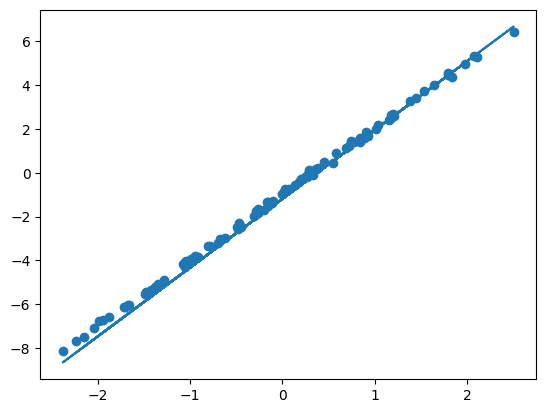

In [28]:
plt.scatter(xs, ys)
plt.plot(xs, model.apply(params, subkey, xs)[0])